# Results of first case study

In [8]:
import numpy as np
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting import GroupNormalizer
from pytorch_forecasting import TemporalFusionTransformer, QuantileLoss
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
import params
import torch
import matplotlib.pyplot as plt

## Load data and model

In [2]:
time_df = pd.read_csv('dataframe.csv', index_col=0, sep=";", decimal=".")
time_df = time_df.reset_index(drop=True)
time_df["is_holiday_or_weekend"] = time_df["is_holiday_or_weekend"].replace(
    {True: 1, False: 0}
)
pattern = r"\d{1,2}\.?\s*[A-Za-z]{3}"
time_df = time_df.replace(pattern, float("nan"), regex=True)
time_df = time_df.ffill(axis=0)
time_df["Dayahead Prices Germany/Luxembourg"] = time_df[
    "Dayahead Prices Germany/Luxembourg"
].astype("float")

training_cutoff = time_df[params.time_idx].max() - params.max_prediction_length
training = TimeSeriesDataSet(
    time_df[lambda x: x.hours_from_start <= training_cutoff],
    time_idx=params.time_idx,
    target=params.target,
    group_ids=params.group_ids,
    min_encoder_length=params.max_encoder_length // 2,
    max_encoder_length=params.max_encoder_length,
    min_prediction_length=params.min_prediction_length,
    max_prediction_length=params.max_prediction_length,
    static_categoricals=params.static_categoricals,
    time_varying_known_reals=params.time_varying_known_reals,
    time_varying_unknown_reals=params.time_varying_unknown_reals,
    target_normalizer=GroupNormalizer(groups=["zone"], transformation="softplus"),
    add_relative_time_idx=params.add_relative_time_idx,
    add_target_scales=params.add_target_scales,
    add_encoder_length=params.add_encoder_length,
    allow_missing_timesteps=True,
)
validation = TimeSeriesDataSet.from_dataset(
    training, time_df, predict=True, stop_randomization=True
)

# if you have a strong GPU, feel free to increase the number of workers
train_dataloader = training.to_dataloader(
    train=True, batch_size=params.batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=params.batch_size * 10, num_workers=0
)


C:\Users\Anwender\AppData\Local\Temp\ipykernel_10136\2580056126.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df["is_holiday_or_weekend"] = time_df["is_holiday_or_weekend"].replace(


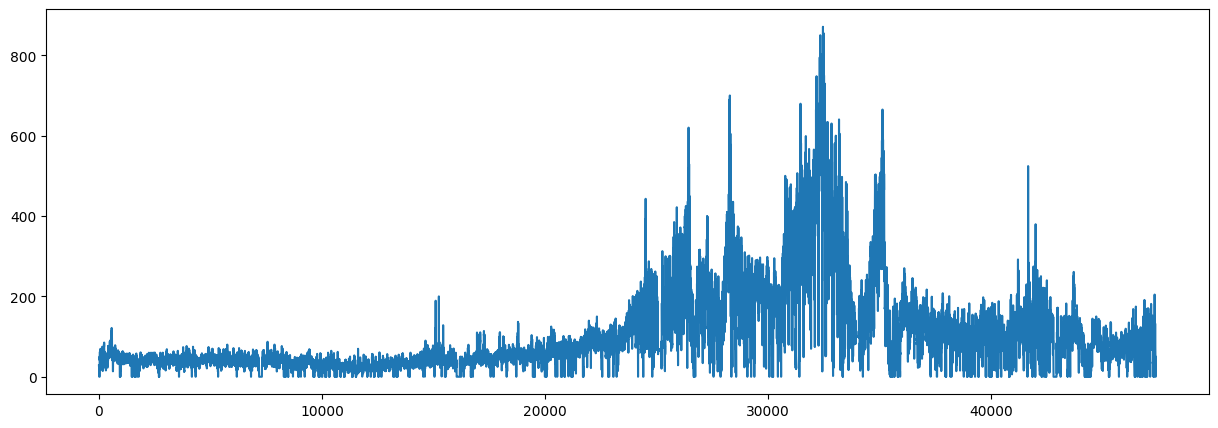

In [18]:
plt.figure(figsize=[15,5])
plt.plot(time_df['Dayahead Prices Germany/Luxembourg'])

In [14]:
# Example (you must use your actual model parameters!)
best_tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=params.learning_rate,
    hidden_size=params.hidden_size,
    attention_head_size=params.attention_head_size,
    dropout=params.dropout,
    hidden_continuous_size=params.hidden_continuous_size,
    output_size=params.output_size,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=params.log_interval,
    reduce_on_plateau_patience=params.reduce_on_plateau_patience,
)

# Load state dict
best_tft.load_state_dict(torch.load("best_tft_cpu.pt", map_location="cpu"))

c:\Users\Anwender\.conda\envs\TST_env\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\Anwender\.conda\envs\TST_env\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


<All keys matched successfully>

In [19]:
best_tft

TemporalFusionTransformer(
  	"attention_head_size":               1
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'hours_from_start', 'target': 'Dayahead Prices Germany/Luxembourg', 'group_ids': ['zone'], 'weight': None, 'max_encoder_length': 168, 'min_encoder_length': 84, 'min_prediction_idx': np.int64(0), 'min_prediction_length': 1, 'max_prediction_length': 24, 'static_categoricals': ['zone'], 'static_reals': None, 'time_varying_known_categoricals': None, 'time_varying_known_reals': ['year', 'day_of_week', 'month', 'hour', 'is_holiday_or_weekend'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['Dayahead Prices Germany/Luxembourg'], 'variable_groups': None, 'constant_fill_strategy': None, 'allow_missing_timesteps': True, 'lags': None, 'add_relative_time_idx': True, 'add_target_scales': True, 'add_encoder_length': True, 'target_normalizer': GroupNormalizer(
  		me

In [5]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to('cpu')
predictions = best_tft.predict(val_dataloader)

#average p50 loss overall
print((actuals - predictions).abs().mean().item())
#average p50 loss per time series
print((actuals - predictions).abs().mean(axis=1))

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


17.073936462402344
tensor([17.0739])


c:\Users\Anwender\.conda\envs\TST_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


In [6]:

#Take a look at what the raw_predictions variable contains

raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)
print(raw_predictions._fields)
#('output', 'x', 'index', 'decoder_lengths', 'y')

print('\n')
print(raw_predictions.output._fields)
# ('prediction',
# 'encoder_attention',
# 'decoder_attention',
# 'static_variables',
# 'encoder_variables',
# 'decoder_variables',
# 'decoder_lengths',
# 'encoder_lengths')

print('\n')
print(raw_predictions.output.prediction.shape)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


('output', 'x', 'index', 'decoder_lengths', 'y')


('prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths')


torch.Size([1, 24, 7])


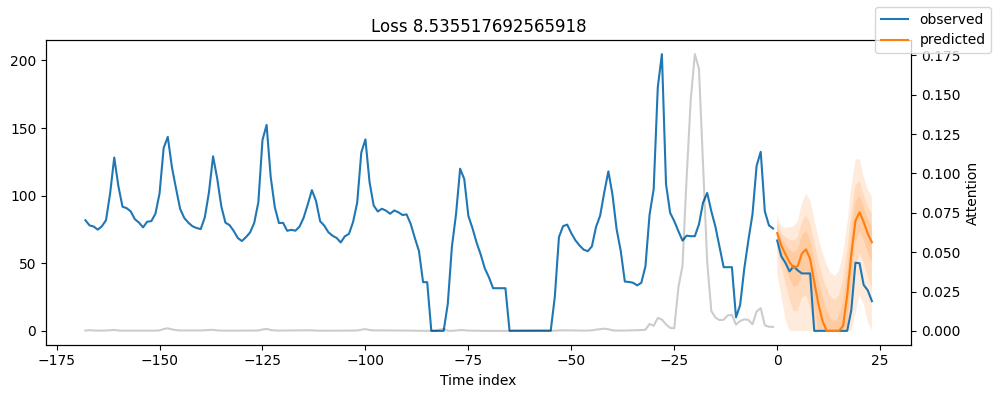

In [9]:
for idx in range(1):  # plot all 5 consumers
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=QuantileLoss(),ax=ax)
    plt.xlabel('time step')
    #plt.ylabel('Day Ahead Price')


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Anwender\.conda\envs\TST_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x375 with 1 Axes>,
 'decoder_variables': <Figure size 700x350 with 1 Axes>}

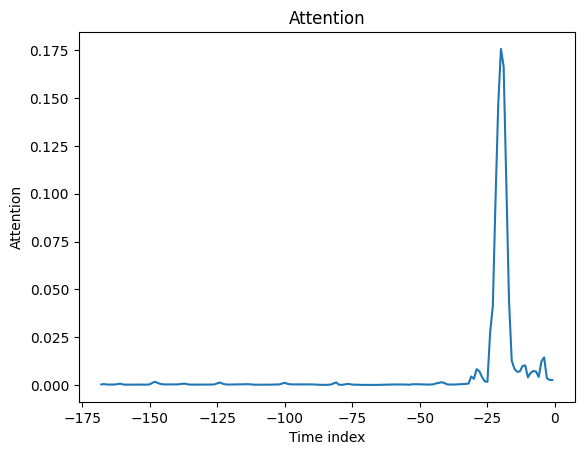

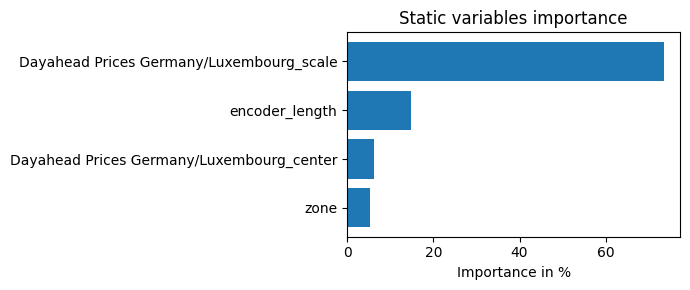

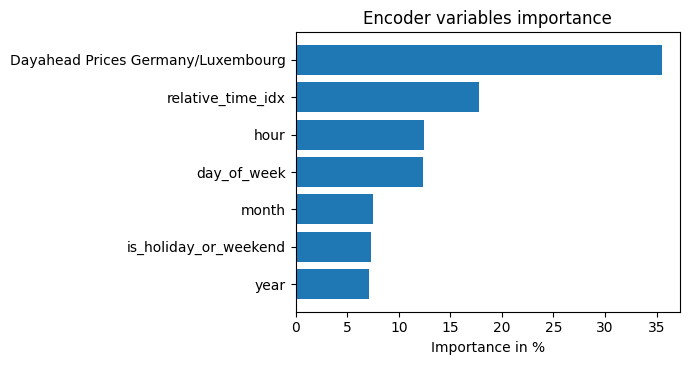

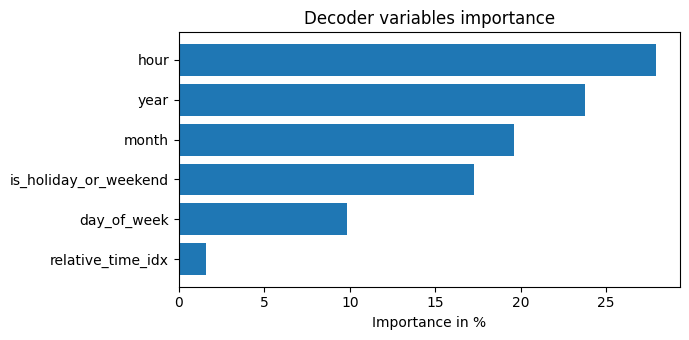

In [13]:
raw_predictions= best_tft.predict(val_dataloader, mode="raw", return_x=True)
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)